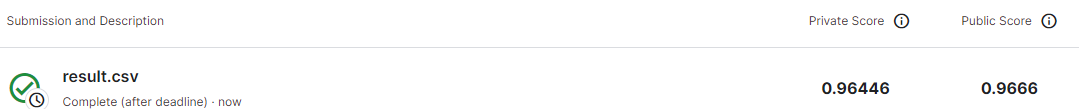

In [8]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


### 이미지 전처리

In [9]:
# 이미지의 크기를 (300, 300)으로 지정합니다.
IMAGE_SIZE = (300, 300)

# 이미지가 있는 폴더의 경로입니다.
IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
# 테스트 데이터셋 CSV 파일의 경로입니다.
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
# 훈련 데이터셋 CSV 파일의 경로입니다.
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"

# 테스트 데이터셋을 pandas로 로드합니다.
test_data = pd.read_csv(TEST_PATH)
# 훈련 데이터셋을 pandas로 로드합니다.
train_data = pd.read_csv(TRAIN_PATH)

# 이미지를 로드하는 함수입니다.
def load_image(image_id):
    # 이미지 파일의 경로를 구성합니다.
    file_path = image_id + ".jpg"
    # OpenCV를 사용하여 이미지를 읽어옵니다.
    image = cv2.imread(IMAGE_PATH + file_path)

    # 이미지를 원하는 크기로 조정합니다.
    image = cv2.resize(image, IMAGE_SIZE)

    # 이미지의 색 공간을 BGR에서 RGB로 변환합니다.
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 훈련 데이터셋의 각 이미지 ID에 'load_image' 함수를 적용하여 이미지를 로드합니다.
images = train_data["image_id"].apply(load_image)

In [10]:
# 이미지들을 numpy 배열로 변환하여 하나의 배열로 스택합니다.
images = np.stack(images)

# 라벨을 가져옵니다. train_data에서 "healthy", "multiple_diseases", "rust", "scab" 열에 해당하는 값들을 가져옵니다.
# values를 사용하여 numpy 배열로 변환합니다.
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

In [11]:
# 배치 크기를 4로 지정합니다.
BATCH_SIZE = 4
# 학습률을 0.00025로 지정합니다.
LEARNING_RATE = 0.00025
# 클래스 수를 4로 지정합니다.
K_NUM = 4

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3

# EfficientNetV2B3 모델을 불러옵니다.
# include_top=False로 설정하여 상단 레이어를 포함하지 않고 모델을 로드합니다.
# 'imagenet' 가중치를 사용합니다.
# 입력 이미지의 크기는 IMAGE_SIZE[1] x IMAGE_SIZE[0] x 3입니다.
efmodel = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE[1], IMAGE_SIZE[0], 3))

model = Sequential()  # Sequential 모델을 생성합니다.
model.add(efmodel)  # EfficientNetV2B3 모델을 추가합니다.
model.add(GlobalAveragePooling2D())  # Global Average Pooling2D 레이어를 추가합니다.
model.add(Dense(K_NUM, activation='softmax'))  # K_NUM(클래스 수)개의 노드를 가진 Dense 레이어를 추가하고, softmax 활성화 함수를 적용합니다.

# 모델을 컴파일합니다.
# 손실 함수로 categorical_crossentropy를 사용하고, Adam 옵티마이저를 사용합니다.
# 학습률은 LEARNING_RATE로 지정하며, 정확도를 평가 지표로 설정합니다.
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 16, 16, 1536)     12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 6148      
                                                                 
Total params: 12,936,770
Trainable params: 12,827,554
Non-trainable params: 109,216
_________________________________________________________________


In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

y_categorical = np.argmax(labels, axis=1)
k = 5  # 폴드 수를 5로 지정합니다.
stratified_kfold = StratifiedKFold(n_splits=k)

history = None
for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(images, y_categorical)):
    if i != K_NUM:
        continue
    
    # 훈련 및 검증 데이터를 나눕니다.
    train_images, val_images = images[train_indices], images[test_indices]
    train_labels, val_labels = labels[train_indices], labels[test_indices]

    # 데이터 증강을 위한 ImageDataGenerator를 설정합니다.
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=15,
        shear_range=0.2,
        zoom_range=[0.9, 1.1],
        brightness_range=[0.8, 1],
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator()

    # 데이터 생성기를 생성합니다.
    train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE, shuffle=True)
    val_generator = train_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE)

    # 모델 체크포인트 및 학습률 감소를 위한 콜백을 설정합니다.
    modelpath = f'./model/train13/kfold{i}/'
    modelname = 'best.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath + modelname, monitor='val_loss', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    # 모델을 학습합니다.
    history = model.fit(train_generator, epochs=80, verbose=1, callbacks=[checkpointer, reduce_lr], validation_data=val_generator)

Epoch 1/80
365/365 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.7968
Epoch 1: val_loss improved from inf to 0.22124, saving model to ./model/train13/kfold4\best.hdf5
365/365 [==============================] - 75s 176ms/step - loss: 0.5991 - accuracy: 0.7968 - val_loss: 0.2212 - val_accuracy: 0.9286 - lr: 2.5000e-04
Epoch 2/80
 26/365 [=>............................] - ETA: 47s - loss: 0.3940 - accuracy: 0.8942

KeyboardInterrupt: 